In [14]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.utils.data
from torch.autograd import Variable

# Load the data

In [15]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


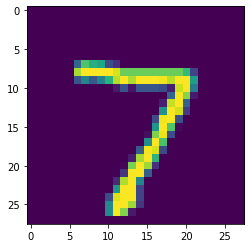

displaying a 7


In [16]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)


    plt.imshow(X[0][0].numpy())
    plt.show()
    print(f'displaying a {y[0]}')
    break

# Define the baseline model

The baseline system should use the following: Glorot initialization, ReLU activations, mini-batch
stochastic gradient descent with momentum (β = 0.9), model selection and a cross-entropy loss
function. Use a learning rate scheduler to adjust the learning rate by 10% every 10 epochs, starting
with a learning rate of 0.05

In [100]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=8)
        self.conv2 = nn.Conv2d(12, 12, kernel_size=8)
        self.fc1 = nn.Linear(7*7*12, 30)
        self.fc2 = nn.Linear(30, 10)

        torch.nn.init.xavier_uniform(self.conv1.weight)
        torch.nn.init.xavier_uniform(self.conv2.weight)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1,7*7*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = BaselineCNN().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

Using cuda device
BaselineCNN(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=588, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=10, bias=True)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Training loop is based on https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [101]:
train_losses = []
test_losses = []

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            train_losses.append(loss)

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    test_losses.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.286559  [    0/60000]
loss: 0.221038  [ 6400/60000]
loss: 0.283953  [12800/60000]
loss: 0.459599  [19200/60000]
loss: 0.179627  [25600/60000]
loss: 0.195077  [32000/60000]
loss: 0.078064  [38400/60000]
loss: 0.090254  [44800/60000]
loss: 0.368524  [51200/60000]
loss: 0.131794  [57600/60000]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.002000 

Epoch 2
-------------------------------
loss: 0.129695  [    0/60000]
loss: 0.124944  [ 6400/60000]
loss: 0.105213  [12800/60000]
loss: 0.133065  [19200/60000]
loss: 0.013133  [25600/60000]
loss: 0.106078  [32000/60000]
loss: 0.050019  [38400/60000]
loss: 0.049517  [44800/60000]
loss: 0.206208  [51200/60000]
loss: 0.065369  [57600/60000]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.001904 

Epoch 3
-------------------------------
loss: 0.098093  [    0/60000]
loss: 0.107061  [ 6400/60000]
loss: 0.056817  [12800/60000]
loss: 0.054821  [19200/60000]
loss: 0.006914  [25600/60000]
loss: 0.090062  [32000/600

Generate learning curves for the validation and training set. Discuss whether this base-
line system overfits, underfits or reasonably fits the validation data. Test this baseline system with
the testing data and report the accuracy and show a confusion matrix

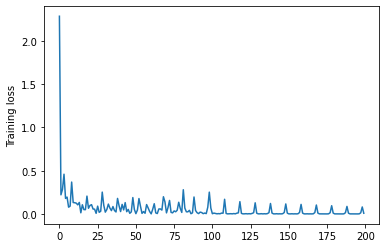

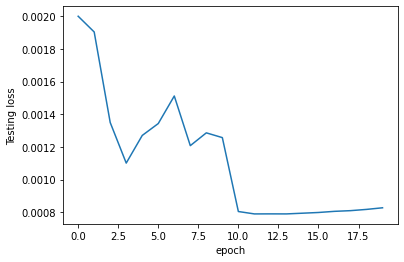

In [102]:
plt.plot(train_losses)
plt.ylabel('Training loss')
plt.show()

plt.plot(test_losses)
plt.ylabel('Testing loss')
plt.xlabel('epoch')
plt.show()

Looks like this model fits pretty well to the testing data. Near the end of the epochs, it looks like some sort of overfitting is going on, since the tseting loss starts increasing a bit near the end, but overall this looks like a pretty good fit to the data!

Accuracy reaches 98.7% on the testing data!